Game player
---

In [21]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')


import importlib

importlib.reload(connect4);


In [22]:
class Player:
    def __init__(self, name = 'Anders', num_actions = 7, random_seed = 2022):
        self.name = name
        self.num_actions = num_actions
        self.rng = np.random.default_rng(random_seed)
        
    def decide_random(self):
        decision = self.rng.choice(self.num_actions)
        return decision

# class C4Model(keras.models.Model):
#     def __init__(self, num_actions = 7, hidden_size = 1080)

class PlayerAC(Player):
    def __init__(self, name = 'Anders', num_actions = 7, hidden_size = 1080, random_seed = 2022):
        super().__init__(name, num_actions, random_seed)
        self.input_layer = tf.keras.Input(shape = (6,7), name = 'input layer')
        self.convolution_h = tf.keras.layers.Conv2D(8,
                                                    (1,4),
                                                    activation='relu',
                                                    input_shape = (6,7),
                                                    name = 'horizontal convolution',
                                                    padding = 'same'
                                                   )
        self.convolution_v = tf.keras.layers.Conv2D(2,
                                                    (5,1),
                                                    activation='relu',
                                                    input_shape = (6,7),
                                                    name = 'vertical convolution',
                                                    padding = 'same'
                                                   )
        self.convolution_square = tf.keras.layers.Conv2D(8,
                                                         (4,4),
                                                         activation='relu',
                                                         input_shape = (6,7),
                                                         name = 'square convolution',
                                                         padding = 'valid'
                                                        )
        self.common1 = tf.keras.layers.Dense(hidden_size,
                                             activation = 'relu',
                                            name = 'common 1')
        self.actor = tf.keras.layers.Dense(num_actions,
                                    activation = 'softmax',
                                    name = 'actor'
                                 )
        self.critic = tf.keras.layers.Dense(1,
                                           activation = 'linear',
                                           name = 'critic')
        
        
    def simple_call(self, this_input):
        inputs = tf.expand_dims(this_input,0)
        x = self.common1(inputs)
        action_probs = self.actor(x)
        critic_value = self.critic(x)
        return tf.squeeze(action_probs), tf.squeeze(critic_value)
        
#give it a 
    def call(self, this_input):
        inputs = tf.expand_dims(this_input,0)
#         inx = self.input_layer(inputs)
        hx = self.convolution_h(inputs)
#         hx = tf.squeeze(hx)
        vx = self.convolution_v(inputs)
#         vx = tf.squeeze(vx)
        sqx = self.convolution_square(inputs)
#         sqx = tf.squeeze(sqx)
        return hx, vx, sqx, tf.squeeze(inputs)
        x = self.common1(keras.layers.concatenate([hx,vx,sqx,tf.squeeze(inputs)]))
        out = self.actor(x)
        return hx, vx, sqx, x, out
#         x = self.common1(tf.squeeze(hx,1))
#         out = self.actor(x)
#         return x
        

In [23]:
c4 = connect4.ConnectFour()

In [24]:
c4.grid.astype('float32')

array([[0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [25]:
c4.count_adjacent(0,0,0)

3

In [26]:
c4.count_adjacent(1,3,0)

8

In [27]:
player = PlayerAC()

In [28]:
first_result = player.simple_call(tf.convert_to_tensor(c4.grid.reshape(6*7).astype('float32')))
first_result

(<tf.Tensor: shape=(7,), dtype=float32, numpy=
 array([0.14285715, 0.14285715, 0.14285715, 0.14285715, 0.14285715,
        0.14285715, 0.14285715], dtype=float32)>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0>)

random game with two players
---

In [29]:
np.argmax(first_result[0])

0

Player -1 wins in 26 turns.


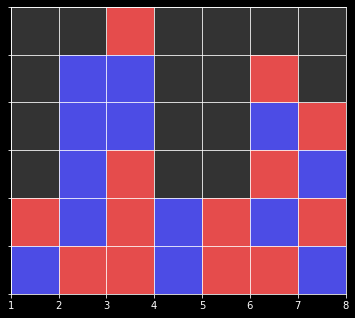

In [30]:
#pit two players against each other
player1 = Player(name='Bea', random_seed=202233)
player2 = Player(name='Chance', random_seed=2025341234542)
c4 = connect4.ConnectFour()

players = [player1, player2]
current_player = 0
board_changed = False
while not c4.done:
    board_changed = c4.play(players[current_player].decide_random())
    if board_changed:
        current_player = not current_player
        
        
c4.show()

Game with simple NN players
---

Player 1 wins in 25 turns.


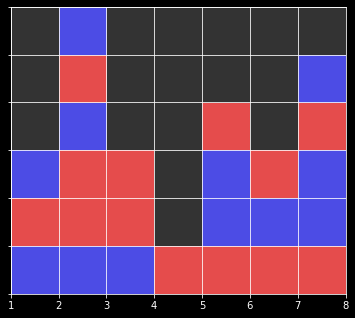

In [31]:
#pit two players against each other
player1 = PlayerAC(name='Bea', hidden_size=2048, random_seed=2022)
player2 = PlayerAC(name='Chance', hidden_size=1024, random_seed=2022)
c4 = connect4.ConnectFour()

rng_seed = 329454319

rng = np.random.default_rng(rng_seed)

players = [player1, player2]
current_player = 0
board_changed = False
while not c4.done:
    reshaped_grid = tf.convert_to_tensor(c4.grid.reshape(6*7).astype('float32'))
    result = players[current_player].simple_call(reshaped_grid)
    action_probs = tf.squeeze(result[0]).numpy()
    player_call = rng.choice(7, p=action_probs)
    board_changed = c4.play(player_call)
    if board_changed:
        current_player = not current_player
        
        
c4.show()

recursive training
---

In [36]:
reward_for_win = 50
reward_for_adjacent = 1

In [ ]:
num_games = 1000

rng = np.random.default_rng(rng_seed)

learning_rate = tf.optimizers.schedules.ExponentialDecay(0.01,100,0.1)
optimizer = tf.optimizers.Adam(learning_rate = learning_rate)

huber = tf.losses.Huber()

gamma = 0.95

#create master player to play with itself
player = PlayerAC(hidden_size = 2048)

#plaer
for game in num_games:
    
    #set up rewards and results histories for a new game
    rewards = []
    actions = []
    critic_values = []
    action_probs = []
    
    #create new game
    c4 = connect4.ConnectFour()
    
    #play the game until it says its done.
    while not c4.done:
        reshaped_grid = tf.convert_to_tensor(c4.grid.reshape(6*7).astype('float32'))
        action_probs = tf.squeeze(player.simple_call(reshaped_grid)).numpy()
        player_call = rng.choice(7, p=action_probs)
        board_changed = c4.play(player_call)
        if board_changed:
            current_player = not current_player
        

In [33]:
c4.grid

array([[ 0., -1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0., -1.],
       [ 0., -1.,  0.,  0.,  1.,  0.,  1.],
       [-1.,  1.,  1.,  0., -1.,  1., -1.],
       [ 1.,  1.,  1.,  0., -1., -1., -1.],
       [-1., -1., -1.,  1.,  1.,  1.,  1.]], dtype=float32)

In [35]:
c4.count_adjacent(3,3,1)

3